# UE: uso de Survival Random Forests para predicción del abandono

## Carga de datos

### Lectura de los .csv contenidos en el directorio de trabajo

Como resultado tendremos 5 dataframes.

El fichero Zonas_geograficas.csv está mal formateado: el número de separadores varía en función de la línea. Con la función my.max evitamos que la lectura con read.csv genere en un dataframe mal formado: las líneas tendrán por defecto el número de campos de la línea con mayor número de separadores.

In [3]:
setwd("~/Erreria/UE")

my.max <- function(x) ifelse( !all(is.na(x)), max(x, na.rm=T), NA)
temp  <-  list.files(pattern = "*.csv")

for (i in 1:length(temp))
  assign(gsub(".csv", "", temp[i]), read.csv(temp[i], sep=";", header=F, stringsAsFactors = T, 
            col.names = paste0("V", seq_len(my.max(unlist(lapply(temp[i],
            count.fields, sep=";")[1]))))))

Renombramos las columnas

In [4]:
colnames(Actividad_ventas) <- c("Codigo_punto_venta","Fecha","Codigo_producto","Descripcion_producto","Numero_unidades")
colnames(Clientes) <-  c("Codigo_cliente","Codigo_seccion_censal","Genero","Fecha_nacimiento","Indice_capacidad_economica",
                         "Nivel_estudios")
colnames(Puntos_venta) <-  c("Codigo_punto_venta","Tipo_punto_venta","Codigo_seccion_censal")
colnames(Suscripciones) <- c("Codigo_cliente","Codigo_producto","Descripcion_producto","Fecha_inicio","Fecha_fin")
colnames(Zonas_geograficas) <- c("Nombre_pais","Codigo_comunidad","Nombre_comunidad","Codigo_provincia","Nombre_provincia",
                                 "Codigo_municipio","Nombre_municipio","Codigo_distrito","Codigo_seccion_censal",
                                 "Numero_habitantes","Numero_mujeres","Numero_hombres","Numero_españoles",
                                 "Numero_extranjeros","Numero_casados","Numero_no_casados")

Limpieza del dataframe Zonas_geograficas: elimina valores ausentes

In [5]:
Zonas_geograficas <- Zonas_geograficas[is.na(Zonas_geograficas[17]),]    
Zonas_geograficas <- Zonas_geograficas[, colSums(is.na(Zonas_geograficas)) != nrow(Zonas_geograficas)]
Zonas_geograficas <- Zonas_geograficas[rowSums(is.na(Zonas_geograficas)) == 0,]

Genero la categoría binaria a predecir

In [6]:
Suscripciones$Churn <- ifelse(Suscripciones$Fecha_fin == "00/01/1900", 0, 1)

Tratamiento de fechas:
+ Fecha de nacimiento del cliente deriva en edad
+ Fecha de inicio de la suscripción se cuantifica en una relación basada en meses
+ Fecha de actividad de ventas pasa a formato POSIX

In [7]:
library(lubridate)

Clientes$Fecha_nacimiento <- gsub("/","-",Clientes$Fecha_nacimiento)
yr = duration(num = 1, units = "years")
edad  <-  round(interval(dmy(Clientes$Fecha_nacimiento), Sys.Date())/yr)
Clientes$Edad <- edad

Suscripciones$Fecha_inicio <- gsub("/","-",Suscripciones$Fecha_inicio)
mt = duration(num = 1, units = "months")
cuenta  <-  round(interval(dmy(Suscripciones$Fecha_inicio), Sys.Date())/mt)
Suscripciones$Cuenta <- cuenta

Actividad_ventas$Fecha <- as.Date(Actividad_ventas$Fecha, "%d/%m/%Y")

Warning message:
: package 'lubridate' was built under R version 3.2.5
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



Tratamiento de las variables categóricas: las variables categóricas pasan a ser dummies

In [8]:
dummies <-  model.matrix(~Clientes$Genero)
Clientes$Genero <- dummies[,2]

dummies <-  model.matrix(~Clientes$Indice_capacidad_economica)
Clientes <- cbind(Clientes, dummies[,2:3])

dummies <-  model.matrix(~Clientes$Nivel_estudios)
Clientes <- cbind(Clientes, dummies[,2:4])
colnames(Clientes) <- gsub("Clientes\\$", "", colnames(Clientes))

dummies <-  model.matrix(~Puntos_venta$Tipo_punto_venta)
Puntos_venta <- cbind(Puntos_venta, dummies[,2:4])
colnames(Puntos_venta) <- gsub("Puntos_venta\\$", "", colnames(Puntos_venta))

## Descripción de los datos

In [7]:
head(Suscripciones)

,Codigo_cliente,Codigo_producto,Descripcion_producto,Fecha_inicio,Fecha_fin,Churn,Cuenta
1,67439,1,Periodico_1,27-12-2015,00/01/1900,0,5
2,137800,5,Revista_2,31-10-2012,00/01/1900,0,43
3,96002,4,Revista_1,20-02-2014,00/01/1900,0,27
4,118534,4,Revista_1,17-07-2015,00/01/1900,0,10
5,106683,2,Periodico_2,01-05-2012,24/11/2014,1,49
6,82015,5,Revista_2,07-03-2012,00/01/1900,0,51


In [8]:
str(Suscripciones)

'data.frame':	306766 obs. of  7 variables:
 $ Codigo_cliente      : int  67439 137800 96002 118534 106683 82015 134872 76 116318 54781 ...
 $ Codigo_producto     : int  1 5 4 4 2 5 4 2 5 5 ...
 $ Descripcion_producto: Factor w/ 5 levels "Periodico_1",..: 1 5 4 4 2 5 4 2 5 5 ...
 $ Fecha_inicio        : chr  "27-12-2015" "31-10-2012" "20-02-2014" "17-07-2015" ...
 $ Fecha_fin           : Factor w/ 2123 levels "00/01/1900","01/01/2011",..: 1 1 1 1 1664 1 1 1 1 669 ...
 $ Churn               : num  0 0 0 0 1 0 0 0 0 1 ...
 $ Cuenta              : num  5 43 27 10 49 51 50 52 63 17 ...


In [9]:
summary(Suscripciones)

 Codigo_cliente   Codigo_producto  Descripcion_producto Fecha_inicio      
 Min.   :     1   Min.   :1       Periodico_1:61416     Length:306766     
 1st Qu.: 37921   1st Qu.:2       Periodico_2:61312     Class :character  
 Median : 75848   Median :3       Periodico_3:61173     Mode  :character  
 Mean   : 75902   Mean   :3       Revista_1  :61465                       
 3rd Qu.:113827   3rd Qu.:4       Revista_2  :61400                       
 Max.   :151867   Max.   :5                                               
                                                                          
      Fecha_fin          Churn         Cuenta     
 00/01/1900:245413   Min.   :0.0   Min.   : 1.00  
 30/04/2016: 15255   1st Qu.:0.0   1st Qu.:20.00  
 10/08/2015:    45   Median :0.0   Median :39.00  
 18/05/2013:    45   Mean   :0.2   Mean   :39.02  
 22/04/2014:    42   3rd Qu.:0.0   3rd Qu.:58.00  
 04/04/2013:    41   Max.   :1.0   Max.   :77.00  
 (Other)   : 45925                         

La tasa de abandono es de un 20%:

In [11]:
table(Suscripciones$Churn)/nrow(Suscripciones)*100


       0        1 
80.00007 19.99993 

En caso de tratar la variable Número de habitantes sería necesario expresarla en logaritmos dada su enorme variabilidad:

In [12]:
range(as.numeric(na.omit(Zonas_geograficas$Numero_habitantes)))

[1]    10 13070

Número de clientes:

In [13]:
length(unique(Clientes$Codigo_cliente))

[1] 151867

Problema: la distribución de los meses de vida de la suscripción no está normalizada:

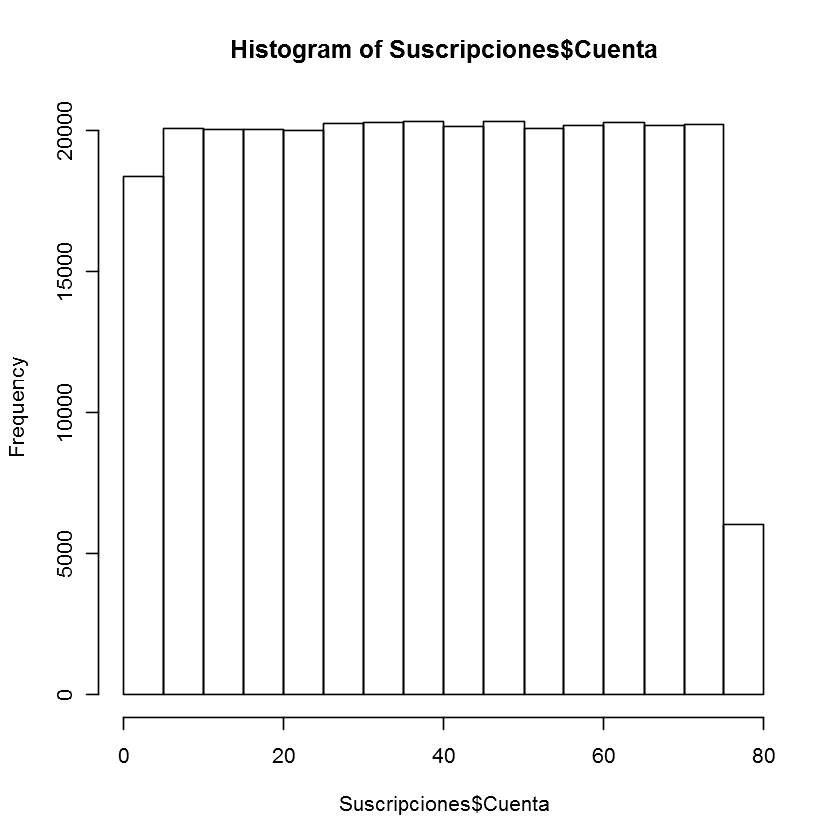

In [15]:
hist(Suscripciones$Cuenta)

## Manipulación de datos

Creamos tres datasets:
+ Datos: contiene la información principal necesaria para el análisis. Sería preferible dividirlo en base a la variable código de producto
+ Datos2: es útil para generar una serie temporal de las ventas
+ Datos3: unión de los dos anteriores

In [9]:
library(dplyr)

Datos <-  inner_join(select(Clientes, -(Fecha_nacimiento:Nivel_estudios)), 
                     select(Suscripciones, -(Descripcion_producto:Fecha_fin)), by = "Codigo_cliente")
Datos$Codigo_seccion_censal <- as.factor(gsub("'", "", Datos$Codigo_seccion_censal))
Datos <-  inner_join(Datos, select(Zonas_geograficas, -(grep("Nombre|Numero", colnames(Zonas_geograficas)))), 
                     by = "Codigo_seccion_censal")

Datos2 <-  inner_join(select(Puntos_venta, -(2)), select(Actividad_ventas, -(4)), by = "Codigo_punto_venta")
Datos2$Codigo_seccion_censal <- gsub("'", "", Datos2$Codigo_seccion_censal)

Datos3 <-  inner_join(Datos, Datos2, by = "Codigo_seccion_censal")

Datos3 <- select(Datos3, -(Codigo_seccion_censal))
Datos <- select(Datos, -(Codigo_seccion_censal))


Attaching package: 'dplyr'

The following objects are masked from 'package:lubridate':

    intersect, setdiff, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
In inner_join_impl(x, y, by$x, by$y): joining factors with different levels, coercing to character vector

Una muestra de los datasets que resultarían de la división por código de producto:

In [17]:
library(plyr)

t.prod <- ddply(Datos3, .(Codigo_producto.x), .fun=nrow)
t.prod <- t.prod[order(t.prod$V1),]
t.prod

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: 'plyr'

The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from 'package:lubridate':

    here



,Codigo_producto.x,V1
2,2,191149
5,5,192584
1,1,193014
4,4,195697
3,3,196620


División de datos en entrenamiento y prueba en un ratio .7/1

In [10]:
set.seed(125)

Datos[,"train"] <- ifelse(runif(nrow(Datos))<0.7,1,0)

trainset <- Datos[Datos$train==1,]
testset <- Datos[Datos$train==0,]

trainset <- trainset[ , !(names(trainset) %in% c("train"))]
testset <- testset[ , !(names(testset) %in% c("train"))]

## Modelado de datos

In [19]:
library(doParallel)

registerDoParallel(detectCores() - 1 )
options(rf.cores = detectCores() - 1, 
        mc.cores = detectCores() - 1)

library(randomForestSRC)
library(ggRandomForests)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Warning message:
: package 'randomForestSRC' was built under R version 3.2.5
 randomForestSRC 2.2.0 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 

Warning message:
: package 'ggRandomForests' was built under R version 3.2.5

Es necesario que las variables sean de tipo numérico.

In [11]:
Probando <-  select(trainset, -(Codigo_municipio:Codigo_distrito))
Probando$Codigo_cliente <- as.numeric(Probando$Codigo_cliente)
Probando$Codigo_producto <- as.numeric(Probando$Codigo_producto)
Probando$Codigo_comunidad <- as.numeric(Probando$Codigo_comunidad)
Probando$Codigo_provincia <- as.numeric(Probando$Codigo_provincia)

Función rfsrc: Random Forests for Survival, Regression and Classification. Cf. http://www.inside-r.org/packages/cran/randomForestSRC/docs/rfsrc

In [21]:
rsf <- rfsrc(Surv(Cuenta, Churn) ~ . , 
                   data = Probando,
                   importance = T,
                   ntree = 3, 
                   nsplit = 2)

Para reducir el ratio de error habría que aumentar el número de árboles del modelo

In [22]:
rsf

                         Sample size: 185827
                    Number of deaths: 37028
                     Number of trees: 3
          Minimum terminal node size: 3
       Average no. of terminal nodes: 37930
No. of variables tried at each split: 4
              Total no. of variables: 11
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank *random*
       Number of random split points: 2
                          Error rate: 49.88%


La capacidad explicativa de las variables independientes respecto a la dependiente (olvidé quitar código de cliente):

In [24]:
imp.rsf <- sort(rsf$importance, 
                  decreasing = T)
imp.rsf

Edad                  Codigo_cliente 
                   0.0033570041                    0.0014001999 
                Codigo_producto    Nivel_estudiosUniversitarios 
                   0.0013046341                    0.0008169825 
               Codigo_comunidad      Nivel_estudiosSin Estudios 
                   0.0006089458                    0.0005765678 
Indice_capacidad_economicaMedia  Indice_capacidad_economicaBaja 
                   0.0001556938                   -0.0004247105 
      Nivel_estudiosSecundarios                Codigo_provincia 
                  -0.0004799900                   -0.0005381484 
                         Genero 
                  -0.0011681473

Warning message:
: Stacking not well defined when ymin != 0

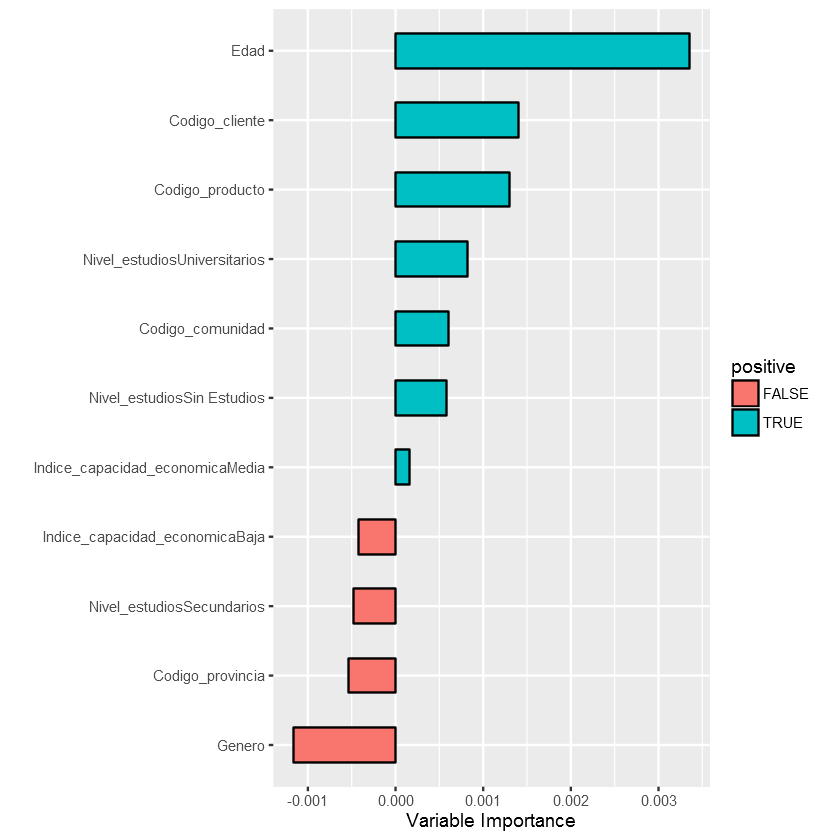

In [25]:
plot(gg_vimp(rsf))

## Probando el modelo

In [36]:
test <-  select(testset, -(Codigo_municipio:Codigo_distrito))
test$Codigo_cliente <- as.numeric(test$Codigo_cliente)
test$Codigo_producto <- as.numeric(test$Codigo_producto)
test$Codigo_comunidad <- as.numeric(test$Codigo_comunidad)
test$Codigo_provincia <- as.numeric(test$Codigo_provincia)

In [37]:
pred.test = predict(rsf, newdata = test, importance = "none")

El índice C de concordancia establece cuál es la probabilidad para que eligiendo dos clientes al azar el que tiene más riesgo experimente antes el evento de abandono que el cliente con menos riesgo. Un valor de 0.5 implica azar puro, por consiguiente el modelo propuesto dista mucho de ser predictivo.

In [38]:
rcorr.cens(-pred.test$predicted , 
             Surv(test$Cuenta, test$Churn))["C Index"]

C Index 
0.5063959

En la curva ROC podemos comprobar, nuevamente, que el modelo es azaroso.

[1] 0.5006924

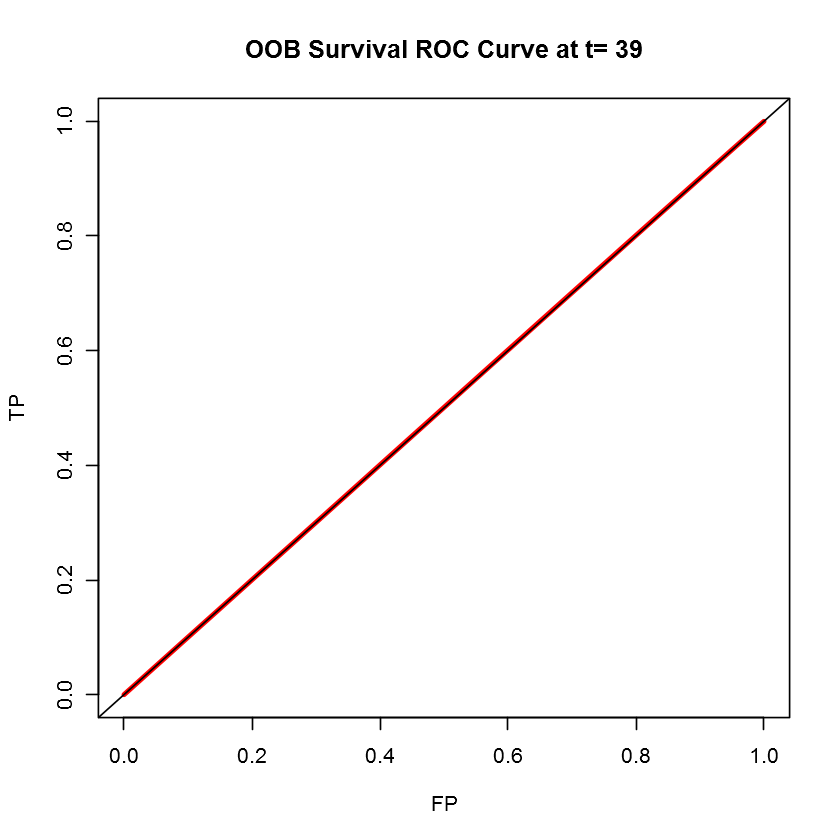

In [41]:
library(risksetROC)

ROC = risksetROC(Stime = Probando$Cuenta,  
                   status = Probando$Churn, 
                   marker = rsf$predicted.oob, 
                   predict.time = median(Probando$Cuenta), 
                   method = "Cox", 
                   main = paste("OOB Survival ROC Curve at t=", 
                                median(Probando$Cuenta)), 
                   lwd = 3, 
                   col = "red" )

ROC$AUC

## Otras pruebas

Con **Recursive Partitioning and Regression Trees** Es sólo una prueba. Para que funcionara correctamente los datos debieran ser convertidos a tipo factor.

In [42]:
library(rpart)

rpart_model <- rpart(Churn ~.,data = Probando, method="class")

Calidad del modelo:

In [43]:
typeColNum <- grep("Churn",names(Probando))
rpart_predict <- predict(rpart_model,test[,-typeColNum],type="class")
mean(rpart_predict==test$Churn)

[1] 0.7993399

La tabla de contingencia muestra que el 80% de predicción se obtiene en base a que, como veímos antes, hay un 80% de población fiel. Por consiguiente, el modelo no aporta ningún nuevo conocimiento. 

In [44]:
table(pred=rpart_predict,true=test$Churn)

    true
pred     0     1
   0 63454 15929
   1     0     0

In [57]:
plot(rpart_model)

ERROR: Error in plot.rpart(rpart_model): fit is not a tree, just a root


Por **regresión logística**:

In [12]:
model <- glm (Churn ~ Edad, Cuenta, data = Probando, family = binomial)

In [48]:
summary(model)


Call:
glm(formula = Churn ~ Edad, family = binomial, data = Probando, 
    weights = Cuenta)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-5.865  -4.862  -3.640  -1.629  15.796  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -1.405e+00  2.770e-03 -507.079  < 2e-16 ***
Edad         2.958e-04  6.357e-05    4.653 3.27e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7241580  on 185826  degrees of freedom
Residual deviance: 7241558  on 185825  degrees of freedom
AIC: 7241562

Number of Fisher Scoring iterations: 6


In [14]:
predict <- predict(model, type = 'response')

In [51]:
table(Probando$Churn, predict > 0.5)

   
     FALSE
  0 148799
  1  37028

## Conclusión

## Referencias